In [90]:
!pip install pandas scikit-learn matplotlib seaborn plotly tensorflow

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [102]:
base_censo = pd.read_csv('data/adult.data', names=column_names, sep=", ", engine='python')
print("Distribuição das classes antes do balanceamento:")
print(base_censo['income'].value_counts())

Distribuição das classes antes do balanceamento:
income
<=50K    24720
>50K      7841
Name: count, dtype: int64


In [103]:
X_censo = base_censo.iloc[:, 0:14].values
y_censo = base_censo.iloc[:, 14].values

In [104]:
label_encoder_workclass = LabelEncoder()
label_encoder_education = LabelEncoder()
label_encoder_marital = LabelEncoder()
label_encoder_occupation = LabelEncoder()
label_encoder_relationship = LabelEncoder()
label_encoder_race = LabelEncoder()
label_encoder_sex = LabelEncoder()
label_encoder_country = LabelEncoder()

X_censo[:,1] = label_encoder_workclass.fit_transform(X_censo[:,1])
X_censo[:,3] = label_encoder_education.fit_transform(X_censo[:,3])
X_censo[:,5] = label_encoder_marital.fit_transform(X_censo[:,5])
X_censo[:,6] = label_encoder_occupation.fit_transform(X_censo[:,6])
X_censo[:,7] = label_encoder_relationship.fit_transform(X_censo[:,7])
X_censo[:,8] = label_encoder_race.fit_transform(X_censo[:,8])
X_censo[:,9] = label_encoder_sex.fit_transform(X_censo[:,9])
X_censo[:,13] = label_encoder_country.fit_transform(X_censo[:,13])

In [105]:
onehotencoder_censo = ColumnTransformer(
    transformers=[('OneHot', OneHotEncoder(), [1,3,5,6,7,8,9,13])],
    remainder='passthrough'
)
X_censo = onehotencoder_censo.fit_transform(X_censo).toarray()

In [106]:
X_50k = X_censo[y_censo == '<=50K']
y_50k = y_censo[y_censo == '<=50K']
X_mais_50k = X_censo[y_censo == '>50K']
y_mais_50k = y_censo[y_censo == '>50K']

# Garantir que o tamanho da amostra seja ao menos 1
sample_size_50k = max(min(int(0.30 * len(y_50k)), len(y_50k)), 1)
sample_size_mais_50k = max(min(int(0.30 * len(y_mais_50k)), len(y_mais_50k)), 1)

# Resampling com tamanho ajustado
X_treinamento_50k, y_treinamento_50k = resample(X_50k, y_50k, replace=False, n_samples=sample_size_50k, random_state=0)
X_treinamento_mais_50k, y_treinamento_mais_50k = resample(X_mais_50k, y_mais_50k, replace=False, n_samples=sample_size_mais_50k, random_state=0)

# Conjunto de teste balanceado
X_teste_50k, y_teste_50k = resample(X_50k, y_50k, replace=False, n_samples=max(5500, 1), random_state=0)
X_teste_mais_50k, y_teste_mais_50k = resample(X_mais_50k, y_mais_50k, replace=False, n_samples=max(2500, 1), random_state=0)

# Combinar conjuntos balanceados
X_censo_treinamento = np.vstack((X_treinamento_50k, X_treinamento_mais_50k))
y_censo_treinamento = np.hstack((y_treinamento_50k, y_treinamento_mais_50k))
X_teste_final = np.vstack((X_teste_50k, X_teste_mais_50k))
y_teste_final = np.hstack((y_teste_50k, y_teste_mais_50k))

In [107]:
sample_size_50k

7416

In [79]:
sample_size_mais_50k

2352

In [109]:
#Normalização dos dados
scaler = StandardScaler()
X_censo_treinamento = scaler.fit_transform(X_censo_treinamento)
X_teste_final = scaler.transform(X_teste_final)

In [117]:
# Configuração do Modelo de Rede Neural
mlp_classifier = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)


In [118]:
# Treinamento do Modelo
mlp_classifier.fit(X_censo_treinamento, y_censo_treinamento)

/Users/lailson/Documents/projetos/census/env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)

In [119]:
# Avaliação do Modelo
previsoes_final = mlp_classifier.predict(X_teste_final)
acuracia_final = accuracy_score(y_teste_final, previsoes_final)
print("Acurácia do modelo MLP com o conjunto de teste ajustado:", acuracia_final)


Acurácia do modelo MLP com o conjunto de teste ajustado: 0.961125


In [115]:
# Exibição da Matriz de Confusão
matriz_confusao_final = confusion_matrix(y_teste_final, previsoes_final)
print("Matriz de Confusão:")
print(matriz_confusao_final)

Matriz de Confusão:
[[5403   97]
 [ 291 2209]]


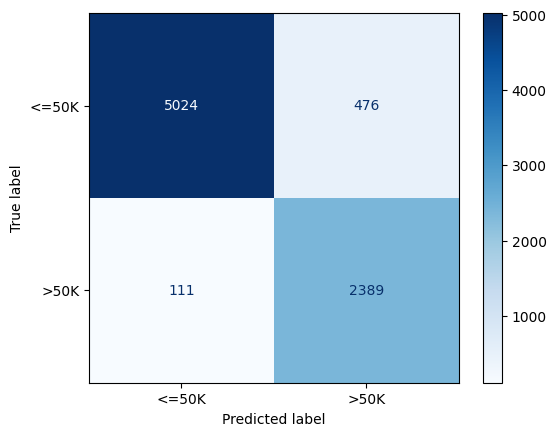

In [87]:
disp_final = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao_final, display_labels=['<=50K', '>50K'])
disp_final.plot(cmap="Blues")
plt.show()

In [86]:
#Relatório de Classificação
relatorio_classificacao_final = classification_report(y_teste_final, previsoes_final, target_names=['<=50K', '>50K'])
print("Relatório de Classificação:")
print(relatorio_classificacao_final)

Relatório de Classificação:
              precision    recall  f1-score   support

       <=50K       0.98      0.91      0.94      5500
        >50K       0.83      0.96      0.89      2500

    accuracy                           0.93      8000
   macro avg       0.91      0.93      0.92      8000
weighted avg       0.93      0.93      0.93      8000



Distribuição das classes antes do balanceamento:
income
<=50K    24720
>50K      7841
Name: count, dtype: int64
Epoch 1/200


/Users/lailson/Documents/projetos/census/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7632 - loss: 0.4978 - val_accuracy: 0.7137 - val_loss: 0.6069
Epoch 2/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.8171 - loss: 0.3858 - val_accuracy: 0.6961 - val_loss: 0.6446
Epoch 3/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.8399 - loss: 0.3581 - val_accuracy: 0.7619 - val_loss: 0.5482
Epoch 4/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - accuracy: 0.8442 - loss: 0.3433 - val_accuracy: 0.7319 - val_loss: 0.5966
Epoch 5/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - accuracy: 0.8483 - loss: 0.3253 - val_accuracy: 0.7064 - val_loss: 0.6370
Epoch 6/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.8551 - loss: 0.3158 - val_accuracy: 0.7378 - val_loss: 0.5852
Epoch 7/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.8469 - loss: 0.3133 - val_accuracy: 0.7692 - val_loss: 0.5313
Epoch 8/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.8626 - loss: 0.2990 - val_ac

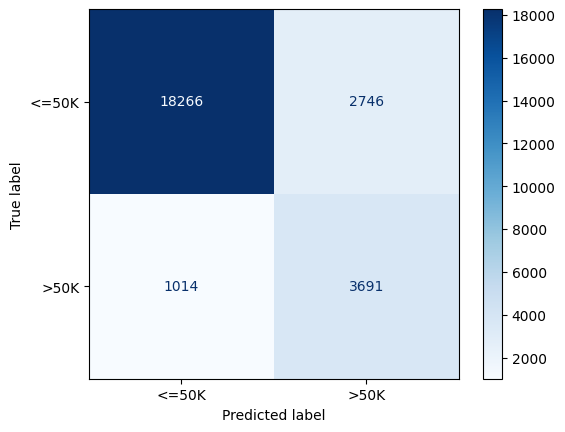


Relatório de Classificação:
              precision    recall  f1-score   support

       <=50K       0.95      0.87      0.91     21012
        >50K       0.57      0.78      0.66      4705

    accuracy                           0.85     25717
   macro avg       0.76      0.83      0.78     25717
weighted avg       0.88      0.85      0.86     25717



In [92]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 1. Nome das colunas com base em adult.names
column_names = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
    "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
    "hours_per_week", "native_country", "income"
]

# 2. Carregamento dos Dados
base_censo = pd.read_csv('data/adult.data', names=column_names, sep=", ", engine='python')
print("Distribuição das classes antes do balanceamento:")
print(base_censo['income'].value_counts())

# 3. Separação de Features (X) e Target (y)
X_censo = base_censo.iloc[:, 0:14].values
y_censo = base_censo.iloc[:, 14].values

# 4. Codificação das Variáveis Categóricas com Label Encoding
label_encoder_workclass = LabelEncoder()
label_encoder_education = LabelEncoder()
label_encoder_marital = LabelEncoder()
label_encoder_occupation = LabelEncoder()
label_encoder_relationship = LabelEncoder()
label_encoder_race = LabelEncoder()
label_encoder_sex = LabelEncoder()
label_encoder_country = LabelEncoder()

X_censo[:,1] = label_encoder_workclass.fit_transform(X_censo[:,1])
X_censo[:,3] = label_encoder_education.fit_transform(X_censo[:,3])
X_censo[:,5] = label_encoder_marital.fit_transform(X_censo[:,5])
X_censo[:,6] = label_encoder_occupation.fit_transform(X_censo[:,6])
X_censo[:,7] = label_encoder_relationship.fit_transform(X_censo[:,7])
X_censo[:,8] = label_encoder_race.fit_transform(X_censo[:,8])
X_censo[:,9] = label_encoder_sex.fit_transform(X_censo[:,9])
X_censo[:,13] = label_encoder_country.fit_transform(X_censo[:,13])

# 5. Codificação com OneHot Encoding
onehotencoder_censo = ColumnTransformer(
    transformers=[('OneHot', OneHotEncoder(), [1,3,5,6,7,8,9,13])],
    remainder='passthrough'
)
X_censo = onehotencoder_censo.fit_transform(X_censo).toarray()

# 6. Balanceamento dos Dados
X_50k = X_censo[y_censo == '<=50K']
y_50k = y_censo[y_censo == '<=50K']
X_mais_50k = X_censo[y_censo == '>50K']
y_mais_50k = y_censo[y_censo == '>50K']

# Amostragem de treinamento com 15% para <=50K e 40% para >50K
X_treinamento_50k, y_treinamento_50k = resample(X_50k, y_50k, replace=False, n_samples=max(int(0.15 * len(y_50k)), 1), random_state=0)
X_treinamento_mais_50k, y_treinamento_mais_50k = resample(X_mais_50k, y_mais_50k, replace=False, n_samples=max(int(0.40 * len(y_mais_50k)), 1), random_state=0)

# Conjunto de teste com o restante
X_teste_50k, y_teste_50k = resample(X_50k, y_50k, replace=False, n_samples=len(y_50k) - len(y_treinamento_50k), random_state=0)
X_teste_mais_50k, y_teste_mais_50k = resample(X_mais_50k, y_mais_50k, replace=False, n_samples=len(y_mais_50k) - len(y_treinamento_mais_50k), random_state=0)

# Combinar conjuntos balanceados
X_censo_treinamento = np.vstack((X_treinamento_50k, X_treinamento_mais_50k))
y_censo_treinamento = np.hstack((y_treinamento_50k, y_treinamento_mais_50k))
X_teste_final = np.vstack((X_teste_50k, X_teste_mais_50k))
y_teste_final = np.hstack((y_teste_50k, y_teste_mais_50k))

# Convertendo a variável alvo para binária
y_censo_treinamento = np.where(y_censo_treinamento == '>50K', 1, 0)
y_teste_final = np.where(y_teste_final == '>50K', 1, 0)

# 7. Normalização dos Dados
scaler = StandardScaler()
X_censo_treinamento = scaler.fit_transform(X_censo_treinamento)
X_teste_final = scaler.transform(X_teste_final)

# 8. Construção do Modelo de Rede Neural com TensorFlow
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_censo_treinamento.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Saída com sigmoide para classificação binária
])

# Compilação do Modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 9. Treinamento do Modelo
history = model.fit(X_censo_treinamento, y_censo_treinamento, epochs=200, batch_size=32, validation_split=0.2)

# 10. Avaliação do Modelo
y_pred_proba = model.predict(X_teste_final)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()
acuracia_final = accuracy_score(y_teste_final, y_pred)
print("\nAcurácia do modelo com o conjunto de teste ajustado:", acuracia_final)

# 11. Exibição da Matriz de Confusão
matriz_confusao_final = confusion_matrix(y_teste_final, y_pred)
print("\nMatriz de Confusão:")
print(matriz_confusao_final)

# Exibindo a matriz de confusão de forma gráfica
disp_final = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao_final, display_labels=['<=50K', '>50K'])
disp_final.plot(cmap="Blues")
plt.show()

# 12. Relatório de Classificação com foco na classe >50K
relatorio_classificacao_final = classification_report(y_teste_final, y_pred, target_names=['<=50K', '>50K'])
print("\nRelatório de Classificação:")
print(relatorio_classificacao_final)
